<a href="https://colab.research.google.com/github/PAkash7/Heating-Air-Quality-Prediction/blob/main/Heat_Measuring_and_Prediction_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heat measuring



Running demo for scenario: default
Generating data for scenario: default
Plotting time series (temp, heating, pm25)


/tmp/ipython-input-327581330.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.date_range(start=start_date, periods=periods, freq=freq)


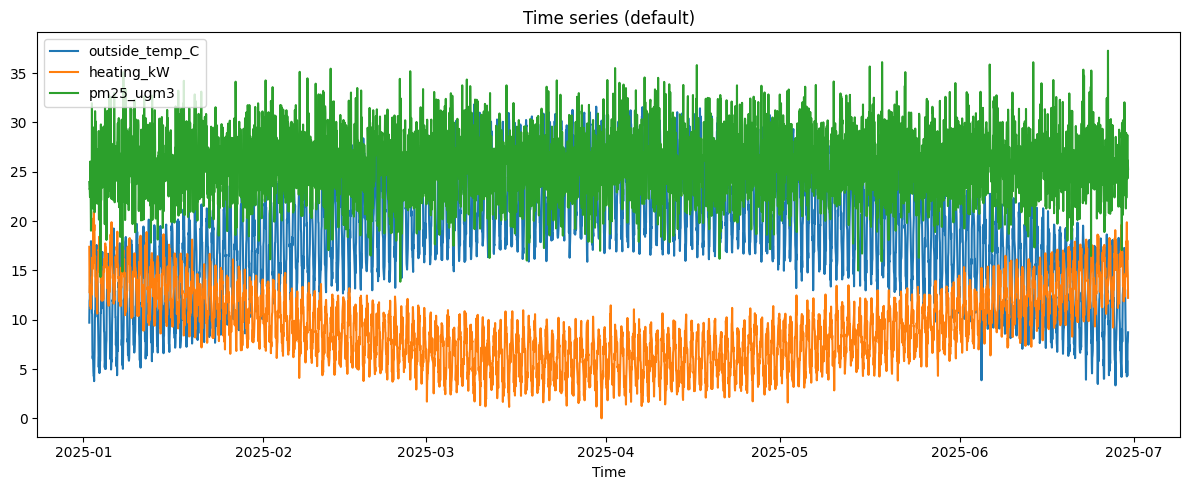

Scatter: outside_temp vs heating_kW


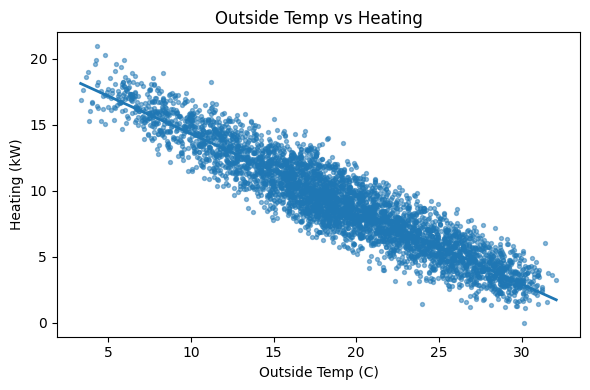

Correlation heatmap (key features)


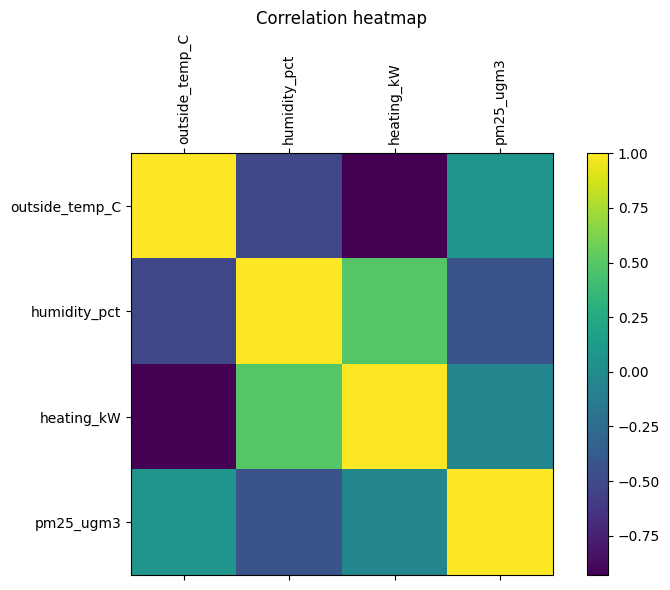

/tmp/ipython-input-327581330.py:203: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill').fillna(method='bfill')


Training heating model (RandomForest)
Heating model MSE: 1.086, R2: 0.847


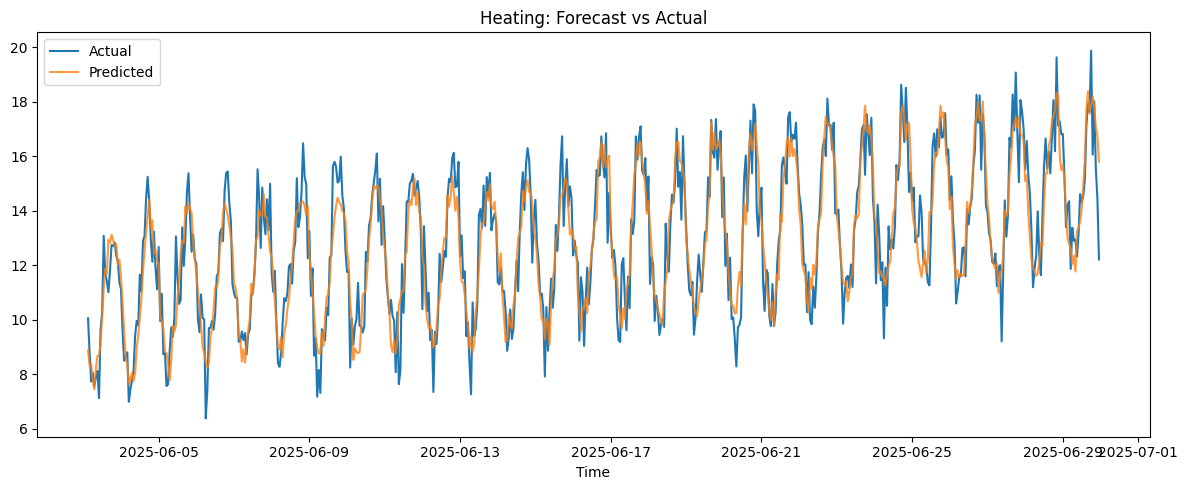

Training PM2.5 model (RandomForest on scaled features)


/tmp/ipython-input-327581330.py:203: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill').fillna(method='bfill')


PM2.5 model MSE: 8.505, R2: 0.208


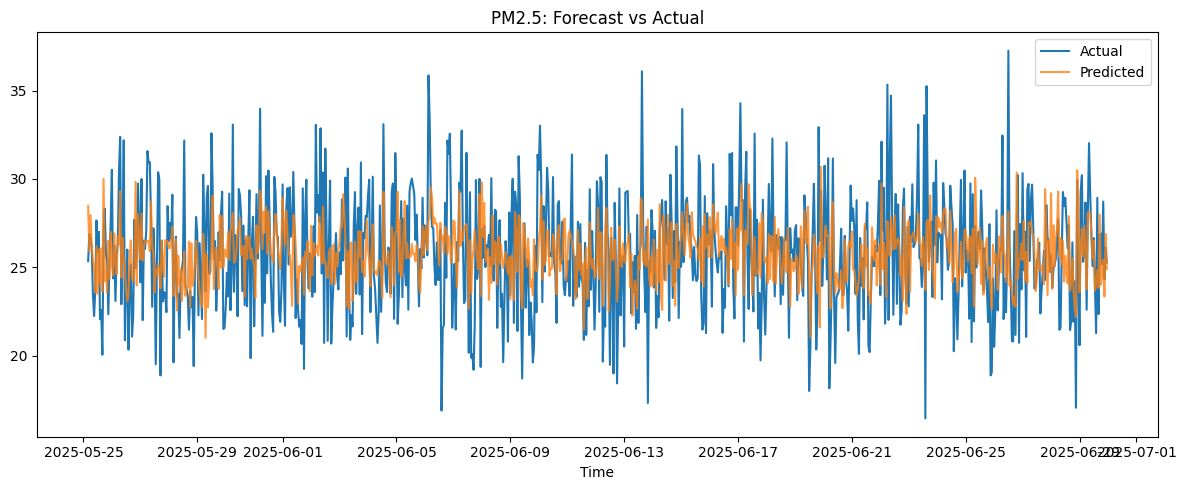

Plot rolling averages and smoothed series


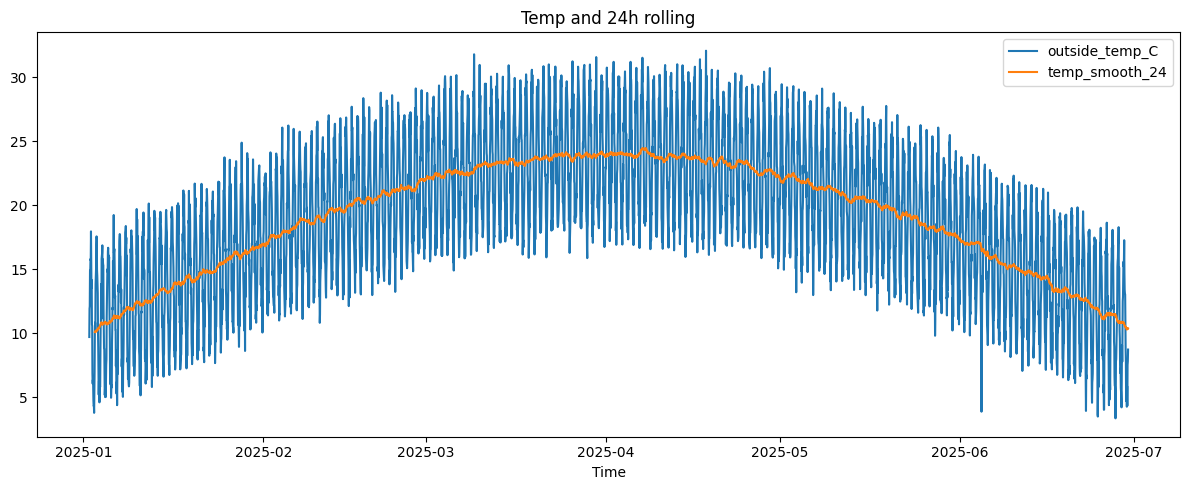

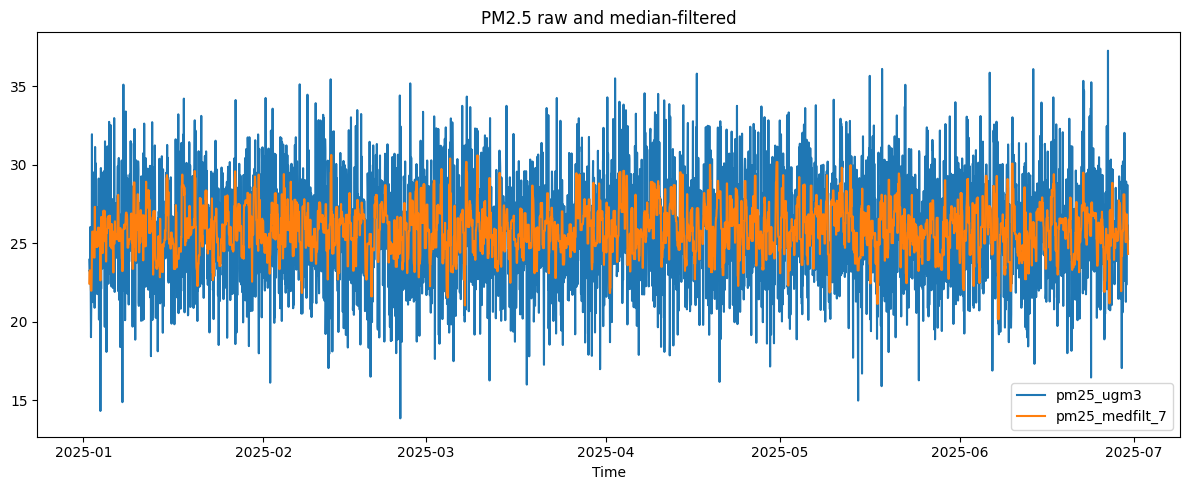

Demo complete. You can now extend: try different models, add weather forecasts, or integrate real data.

Running demo for scenario: cold_wave
Generating data for scenario: cold_wave
Plotting time series (temp, heating, pm25)


/tmp/ipython-input-327581330.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.date_range(start=start_date, periods=periods, freq=freq)


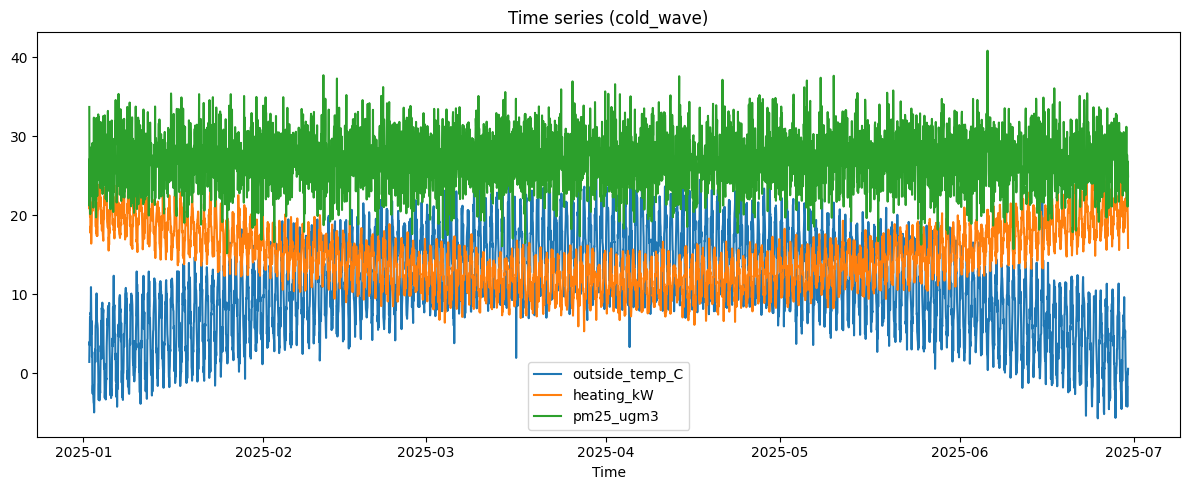

Scatter: outside_temp vs heating_kW


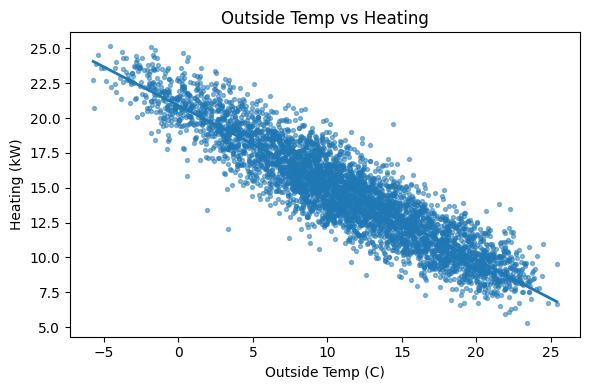

Correlation heatmap (key features)


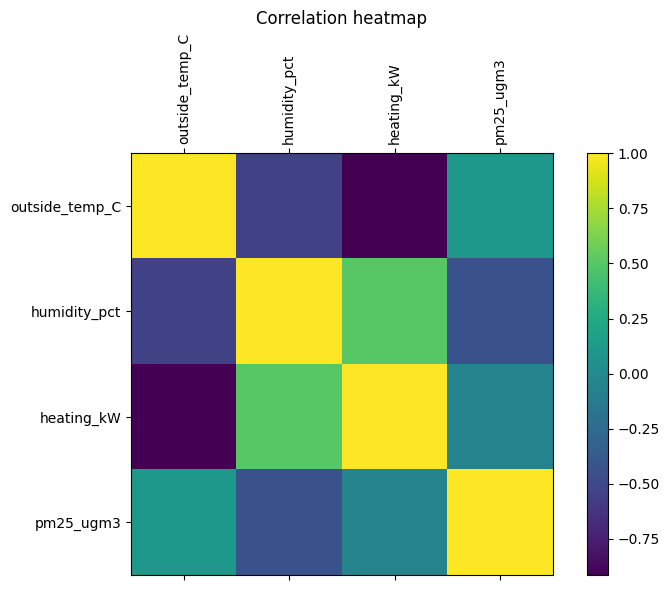

/tmp/ipython-input-327581330.py:203: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill').fillna(method='bfill')


Training heating model (RandomForest)
Heating model MSE: 1.388, R2: 0.796


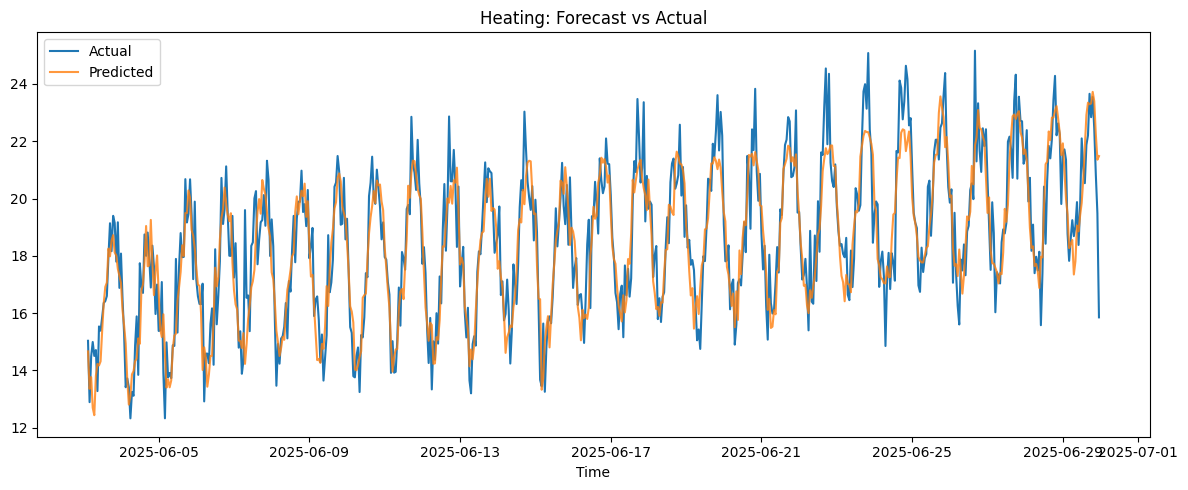

Training PM2.5 model (RandomForest on scaled features)


/tmp/ipython-input-327581330.py:203: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill').fillna(method='bfill')


PM2.5 model MSE: 9.708, R2: 0.190


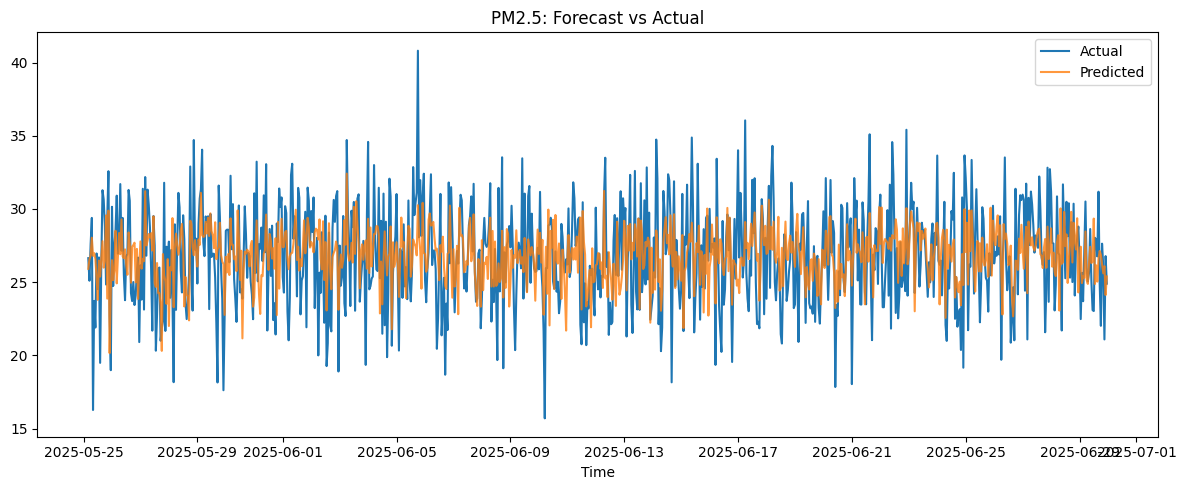

Plot rolling averages and smoothed series


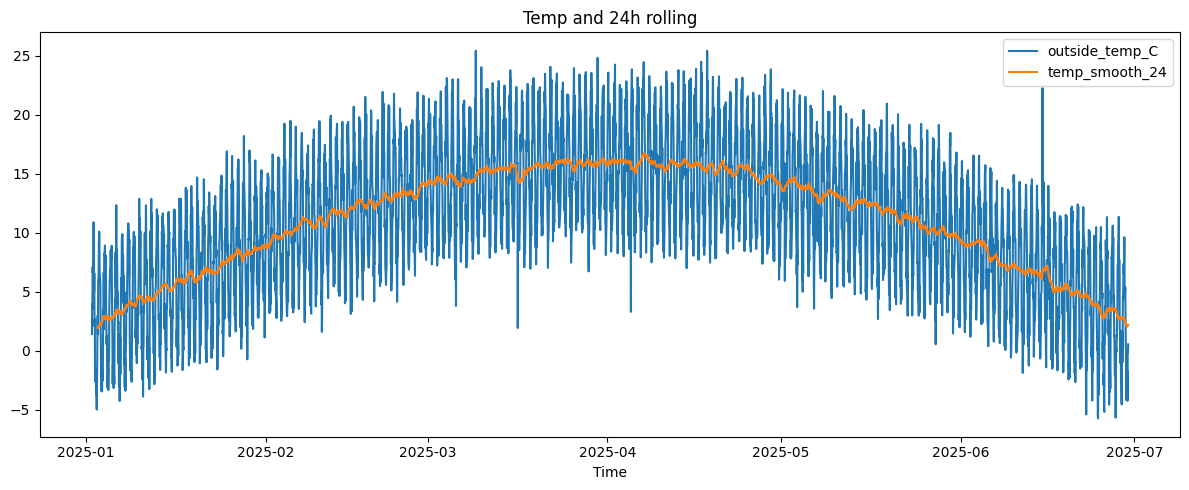

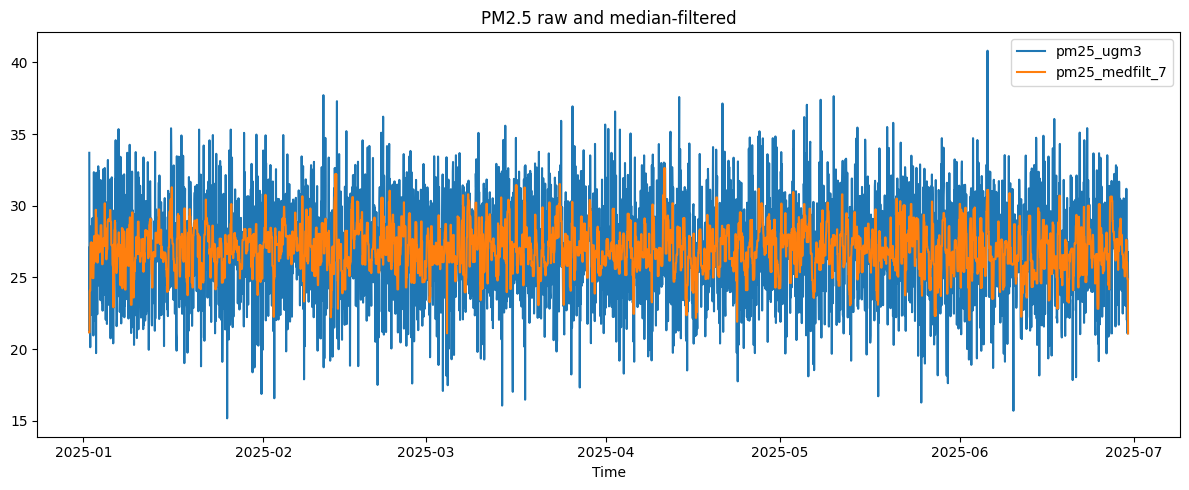

Demo complete. You can now extend: try different models, add weather forecasts, or integrate real data.

Running demo for scenario: pollution_spike
Generating data for scenario: pollution_spike
Plotting time series (temp, heating, pm25)


/tmp/ipython-input-327581330.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.date_range(start=start_date, periods=periods, freq=freq)


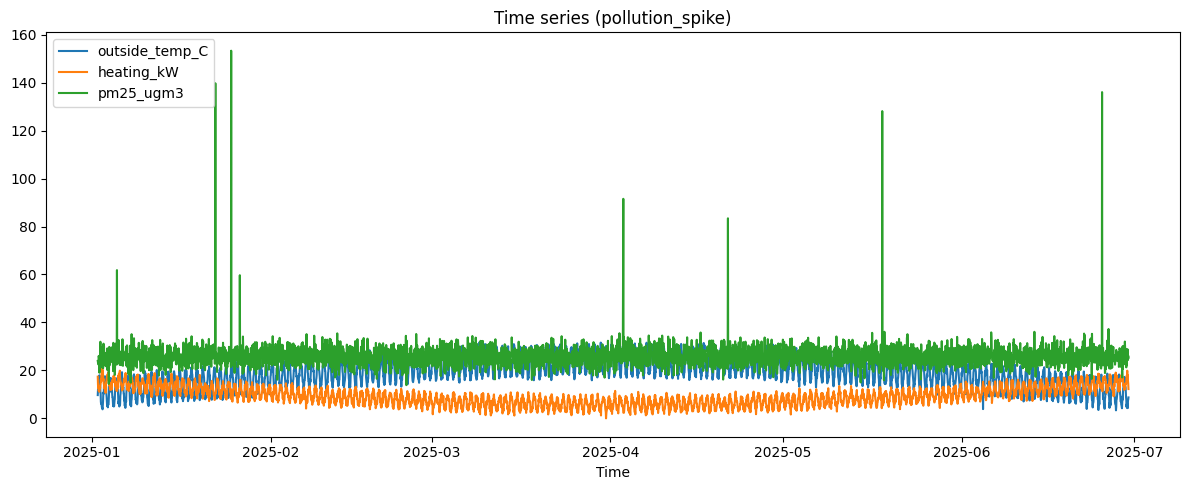

Scatter: outside_temp vs heating_kW


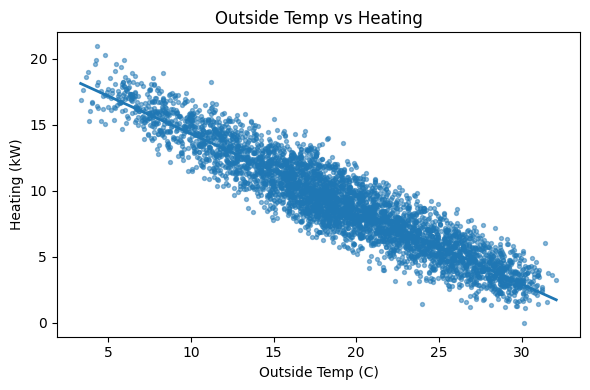

Correlation heatmap (key features)


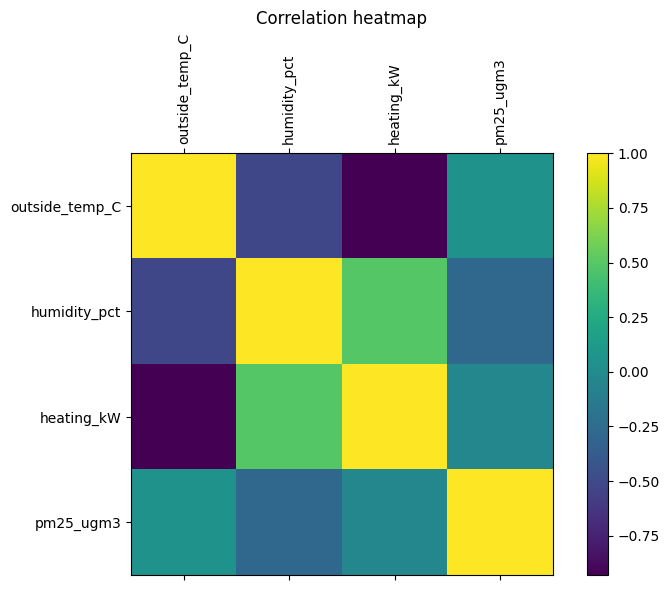

/tmp/ipython-input-327581330.py:203: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill').fillna(method='bfill')


Training heating model (RandomForest)
Heating model MSE: 1.084, R2: 0.847


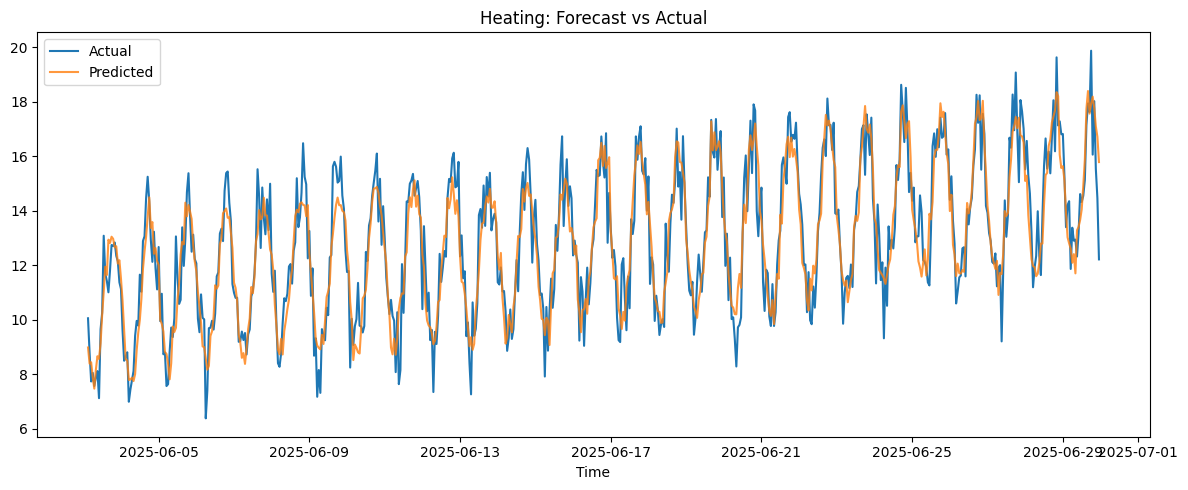

Training PM2.5 model (RandomForest on scaled features)


/tmp/ipython-input-327581330.py:203: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill').fillna(method='bfill')


PM2.5 model MSE: 22.014, R2: 0.115


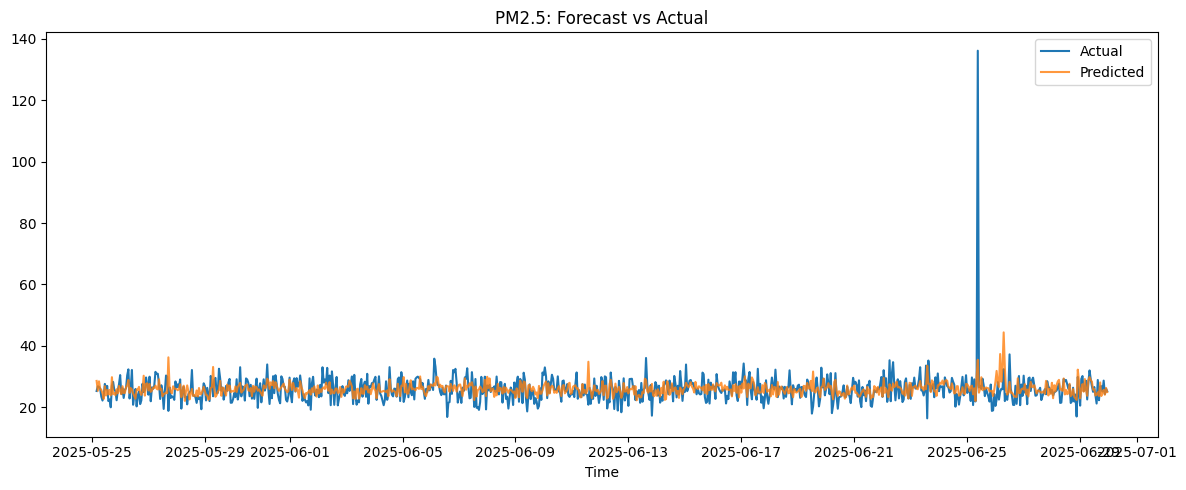

Plot rolling averages and smoothed series


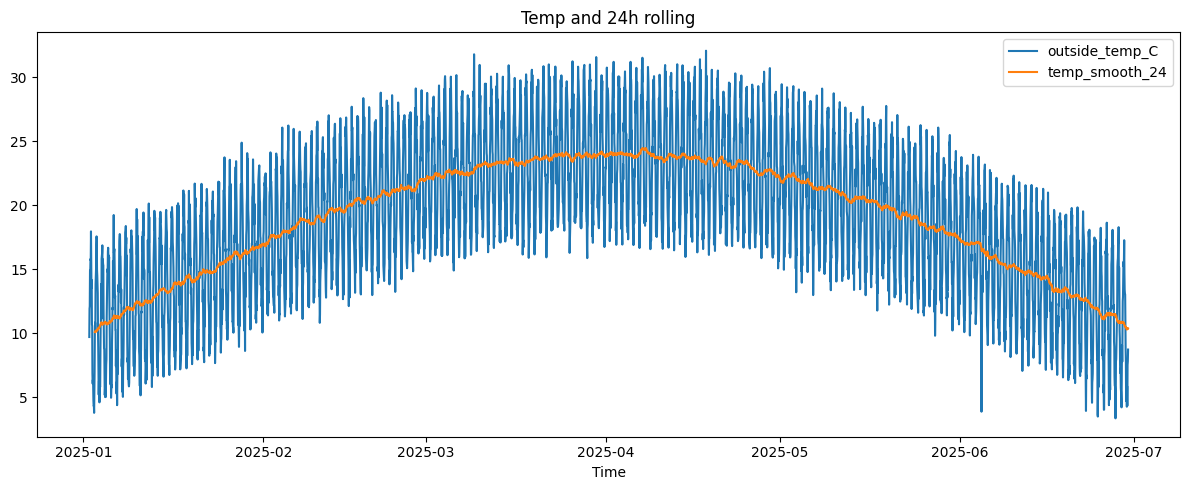

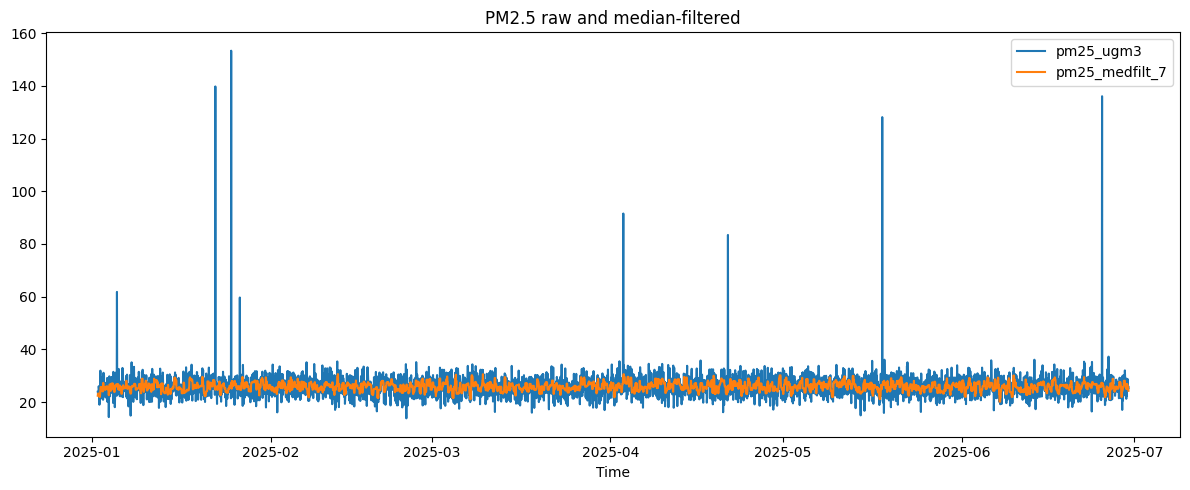

Demo complete. You can now extend: try different models, add weather forecasts, or integrate real data.

All demos finished. Check the displayed plots or adapt the script to save them to files.


In [4]:
import os
import math
import random
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.signal import medfilt

# -------------------------
# 1. Synthetic data generator
# -------------------------

def generate_time_index(start_date: str, periods: int, freq: str = 'H') -> pd.DatetimeIndex:
    """Create a datetime index starting from start_date for `periods` steps with frequency freq.
    Default frequency is hourly ('H').
    """
    return pd.date_range(start=start_date, periods=periods, freq=freq)


def seasonal_signal(t_index, daily_amplitude=5, yearly_amplitude=10, noise_std=1.0,
                    trend_per_day=0.0, spike_probability=0.0, spike_magnitude=10.0):
    """Create a signal composed of daily + yearly seasonality, trend and random spikes.
    t_index should be a pandas.DatetimeIndex.
    """
    n = len(t_index)
    hours = np.arange(n)

    # daily cycle (24-hour)
    daily = daily_amplitude * np.sin(2 * np.pi * hours / 24)
    # yearly cycle (365 days -> 365*24 hours)
    yearly = yearly_amplitude * np.sin(2 * np.pi * hours / (365 * 24))
    # linear trend
    days = hours / 24.0
    trend = trend_per_day * days
    # noise
    noise = np.random.normal(scale=noise_std, size=n)
    # spikes
    spikes = np.zeros(n)
    if spike_probability > 0:
        spike_mask = np.random.rand(n) < spike_probability
        spikes[spike_mask] = np.random.choice([-1, 1], size=spike_mask.sum()) * spike_magnitude * np.random.rand(spike_mask.sum())

    return daily + yearly + trend + noise + spikes


def generate_synthetic_dataset(start_date='2025-01-01', periods=24*365, freq='H', seed=42,
                               scenario='default') -> pd.DataFrame:
    """Generate a dataframe with synthetic weather, heating load, and air quality.
    scenarios allow different sequences: 'default', 'cold_wave', 'pollution_spike', 'trend_up'.
    """
    random.seed(seed)
    np.random.seed(seed)

    t_index = generate_time_index(start_date, periods, freq)

    # Base outside temperature (C)
    if scenario == 'cold_wave':
        temp = seasonal_signal(t_index, daily_amplitude=6, yearly_amplitude=14, noise_std=1.5, trend_per_day=0.0,
                                spike_probability=0.001, spike_magnitude=-15.0)
        temp -= 8  # colder baseline
    elif scenario == 'trend_up':
        temp = seasonal_signal(t_index, daily_amplitude=6, yearly_amplitude=14, noise_std=1.0, trend_per_day=0.005,
                                spike_probability=0.0005, spike_magnitude=6.0)
    else:
        temp = seasonal_signal(t_index, daily_amplitude=6, yearly_amplitude=14, noise_std=1.0, trend_per_day=0.0,
                                spike_probability=0.0005, spike_magnitude=6.0)

    outside_temp = 10 + temp  # shift to realistic range

    # Humidity (0-100%) correlated inversely with temperature a bit
    humidity = 60 - 0.5 * (outside_temp - outside_temp.mean()) + np.random.normal(scale=5, size=len(t_index))
    humidity = np.clip(humidity, 10, 100)

    # Heating load (kW) - higher when outside temp is lower, plus occupancy / daily usage
    # We'll simulate building thermal inertia with a lagged relation
    base_heating = np.maximum(0, 30 - outside_temp)  # simple inverse
    daily_usage = 3 * np.sin(2 * np.pi * np.arange(len(t_index)) / 24) + 5
    # Convolution-like smoothing to represent building thermal inertia
    heating_smoothed = np.convolve(base_heating, np.ones(6)/6, mode='same')
    heating = heating_smoothed * 0.7 + daily_usage * 0.3 + np.random.normal(scale=1.0, size=len(t_index))
    heating = np.maximum(0, heating)

    # Air quality (PM2.5 ug/m3). Base low, rises with stagnation (low wind not simulated), spikes in pollution scenario
    pm25 = 12 + 0.3 * (100 - humidity) + 0.2 * (heating) + np.random.normal(scale=3.0, size=len(t_index))

    if scenario == 'pollution_spike':
        spike_mask = (np.random.rand(len(t_index)) < 0.002)
        pm25[spike_mask] += np.random.uniform(30, 150, size=spike_mask.sum())

    pm25 = np.clip(pm25, 1, 500)

    df = pd.DataFrame({
        'timestamp': t_index,
        'outside_temp_C': np.round(outside_temp, 2),
        'humidity_pct': np.round(humidity, 2),
        'heating_kW': np.round(heating, 3),
        'pm25_ugm3': np.round(pm25, 2)
    }).set_index('timestamp')

    # add lag features and rolling statistics for modeling convenience
    for lag in [1, 3, 6, 24]:
        df[f'temp_lag_{lag}'] = df['outside_temp_C'].shift(lag)
        df[f'hum_lag_{lag}'] = df['humidity_pct'].shift(lag)

    df['heating_roll_24'] = df['heating_kW'].rolling(24, min_periods=1).mean()
    df['pm25_roll_24'] = df['pm25_ugm3'].rolling(24, min_periods=1).mean()

    df = df.dropna().copy()
    return df

# -------------------------
# 2. Plotting utilities
# -------------------------

def plot_time_series(df: pd.DataFrame, cols=None, title=None, figsize=(12, 5), savepath=None):
    if cols is None:
        cols = df.columns[:3]
    plt.figure(figsize=figsize)
    for c in cols:
        plt.plot(df.index, df[c], label=c)
    plt.legend()
    if title:
        plt.title(title)
    plt.xlabel('Time')
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    else:
        plt.show()
    plt.close()


def plot_scatter_with_fit(x, y, xlabel=None, ylabel=None, title=None, savepath=None):
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, s=8, alpha=0.5)
    lr = LinearRegression()
    X = np.array(x).reshape(-1, 1)
    lr.fit(X, y)
    xs = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    plt.plot(xs, lr.predict(xs), linewidth=2)
    if xlabel: plt.xlabel(xlabel)
    if ylabel: plt.ylabel(ylabel)
    if title: plt.title(title)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    else:
        plt.show()
    plt.close()


def plot_correlation_heatmap(df: pd.DataFrame, cols=None, title='Correlation heatmap', savepath=None):
    if cols is None:
        cols = df.columns
    corr = df[cols].corr()
    fig, ax = plt.subplots(figsize=(8, 6)) # Explicitly create figure and axes
    im = ax.matshow(corr) # Plot on the created axes
    plt.colorbar(im, ax=ax) # Link colorbar to the axes and image
    ax.set_xticks(range(len(cols)))
    ax.set_yticks(range(len(cols)))
    ax.set_xticklabels(cols, rotation=90)
    ax.set_yticklabels(cols)
    ax.set_title(title)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    else:
        plt.show()
    plt.close()


def plot_forecast_vs_actual(dates, actual, predicted, title='Forecast vs Actual', savepath=None):
    plt.figure(figsize=(12, 5))
    plt.plot(dates, actual, label='Actual')
    plt.plot(dates, predicted, label='Predicted', alpha=0.8)
    plt.legend()
    plt.title(title)
    plt.xlabel('Time')
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    else:
        plt.show()
    plt.close()

# -------------------------
# 3. Modeling - Heating prediction
# -------------------------

def prepare_features(df: pd.DataFrame, target_col: str = 'heating_kW'):
    feature_cols = [c for c in df.columns if c not in [target_col]]
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    # fill any remaining NaNs
    X = X.fillna(method='ffill').fillna(method='bfill')
    return X, y, feature_cols


def train_evaluate_regressor(X_train, y_train, X_test, y_test, model=None):
    if model is None:
        model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    return model, pred, mse, r2

# -------------------------
# 4. Modeling - Air quality prediction (pm2.5)
# -------------------------

def train_simple_pm25_model(df: pd.DataFrame):
    X, y, cols = prepare_features(df, target_col='pm25_ugm3')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    rf = RandomForestRegressor(n_estimators=100, random_state=1)
    rf.fit(X_train_s, y_train)
    pred = rf.predict(X_test_s)
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    return rf, scaler, X_test.index, y_test, pred, mse, r2

# -------------------------
# 5. Example run and plotting demonstration
# -------------------------

def demo_all(scenario='default'):
    print(f"Generating data for scenario: {scenario}")
    df = generate_synthetic_dataset(start_date='2025-01-01', periods=24*180, scenario=scenario)

    print('Plotting time series (temp, heating, pm25)')
    plot_time_series(df, cols=['outside_temp_C', 'heating_kW', 'pm25_ugm3'], title=f'Time series ({scenario})')

    print('Scatter: outside_temp vs heating_kW')
    plot_scatter_with_fit(df['outside_temp_C'].values, df['heating_kW'].values,
                          xlabel='Outside Temp (C)', ylabel='Heating (kW)',
                          title='Outside Temp vs Heating')

    print('Correlation heatmap (key features)')
    plot_correlation_heatmap(df, cols=['outside_temp_C', 'humidity_pct', 'heating_kW', 'pm25_ugm3'])

    # Prepare features and split
    X, y, feat_cols = prepare_features(df, 'heating_kW')
    # Use the last 15% as test to simulate forecasting
    split = int(len(X) * 0.85)
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]

    print('Training heating model (RandomForest)')
    model, pred_heating, mse_h, r2_h = train_evaluate_regressor(X_train, y_train, X_test, y_test)
    print(f'Heating model MSE: {mse_h:.3f}, R2: {r2_h:.3f}')

    plot_forecast_vs_actual(X_test.index, y_test, pred_heating, title='Heating: Forecast vs Actual')

    print('Training PM2.5 model (RandomForest on scaled features)')
    rf_pm, scaler_pm, pm_dates, pm_actual, pm_pred, pm_mse, pm_r2 = train_simple_pm25_model(df)
    print(f'PM2.5 model MSE: {pm_mse:.3f}, R2: {pm_r2:.3f}')
    plot_forecast_vs_actual(pm_dates, pm_actual, pm_pred, title='PM2.5: Forecast vs Actual')

    # Additional visualizations: rolling windows and different sequences
    print('Plot rolling averages and smoothed series')
    df['temp_smooth_24'] = df['outside_temp_C'].rolling(24).mean()
    df['pm25_medfilt_7'] = medfilt(df['pm25_ugm3'].values, kernel_size=7)
    plot_time_series(df, cols=['outside_temp_C', 'temp_smooth_24'], title='Temp and 24h rolling')
    plot_time_series(df, cols=['pm25_ugm3', 'pm25_medfilt_7'], title='PM2.5 raw and median-filtered')

    print('Demo complete. You can now extend: try different models, add weather forecasts, or integrate real data. By AKASH PANDEY')


if __name__ == '__main__':
    # produce three scenarios and save plots to 'outputs' folder
    outdir = 'outputs'
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    # Run demo for multiple sequences
    for sc in ['default', 'cold_wave', 'pollution_spike']:
        print('\n' + '='*60)
        print(f'Running demo for scenario: {sc}')
        demo_all(scenario=sc)

    print('\nAll demos finished. Check the displayed plots or adapt the script to save them to files.')

# Heat Measuring and Prediction Demo

This notebook provides a comprehensive demonstration of generating synthetic time-series data related to environmental factors and building energy, followed by various data analysis, visualization, and machine learning modeling techniques.

## Table of Contents

1.  [Overview](#overview)
2.  [Features](#features)
3.  [Synthetic Data Generation](#synthetic-data-generation)
4.  [Plotting Utilities](#plotting-utilities)
5.  [Modeling - Heating Prediction](#modeling---heating-prediction)
6.  [Modeling - Air Quality Prediction (PM2.5)](#modeling---air-quality-prediction-pm2-5)
7.  [How to Run the Demo](#how-to-run-the-demo)
8.  [Number System Converter](#number-system-converter)

## Overview

This project simulates environmental and building data (outside temperature, humidity, heating load, and PM2.5 air quality) and demonstrates a workflow for:

*   Generating realistic synthetic time-series data.
*   Visualizing time-series, correlations, and model predictions.
*   Building simple machine learning models (RandomForestRegressor) to predict heating load and PM2.5 levels.
*   Analyzing data under different scenarios (default, cold wave, pollution spike).

## Features

*   **Synthetic Data Generator**: Creates hourly data for outside temperature, humidity, heating demand, and PM2.5 air quality with seasonal cycles, trends, and random noise/spikes.
*   **Plotting Utilities**: Functions to visualize time series, scatter plots with linear fits, correlation heatmaps, and forecast vs. actual comparisons.
*   **Machine Learning Models**: Includes functions to prepare features, train, and evaluate Random Forest Regressor models for predicting heating demand and PM2.5 levels.
*   **Scenario-based Demos**: Demonstrates data generation and analysis under 'default', 'cold_wave', and 'pollution_spike' scenarios.

## Synthetic Data Generation

The `generate_synthetic_dataset` function is the core of the data simulation. It allows you to create data for a specified period and frequency, with options to introduce different scenarios affecting temperature or air quality.

**Key Functions:**

*   `generate_time_index(start_date, periods, freq)`: Creates a pandas DatetimeIndex.
*   `seasonal_signal(...)`: Generates a signal with daily and yearly seasonality, trend, and optional spikes.
*   `generate_synthetic_dataset(...)`: Orchestrates the generation of all features based on specified parameters and scenarios.

## Plotting Utilities

Several functions are provided for quick visualization of the generated data and model results.

**Key Functions:**

*   `plot_time_series(df, cols, title, figsize, savepath)`: Plots selected columns of a DataFrame over time.
*   `plot_scatter_with_fit(x, y, xlabel, ylabel, title, savepath)`: Creates a scatter plot with a linear regression fit.
*   `plot_correlation_heatmap(df, cols, title, savepath)`: Displays a correlation matrix heatmap for specified columns.
*   `plot_forecast_vs_actual(dates, actual, predicted, title, savepath)`: Compares actual values against predicted values over time.

## Modeling - Heating Prediction

This section focuses on predicting the building's heating load (`heating_kW`) based on environmental factors and lagged features.

**Key Functions:**

*   `prepare_features(df, target_col)`: Selects features and target, handling NaNs.
*   `train_evaluate_regressor(X_train, y_train, X_test, y_test, model)`: Trains a regression model (defaulting to RandomForestRegressor) and evaluates its performance (MSE, R2).

## Modeling - Air Quality Prediction (PM2.5)

This section demonstrates predicting PM2.5 air quality using a similar machine learning approach, incorporating feature scaling.

**Key Functions:**

*   `train_simple_pm25_model(df)`: Prepares features, scales them, trains a RandomForestRegressor for PM2.5, and returns performance metrics.

## How to Run the Demo

The `demo_all()` function encapsulates the entire workflow for a given scenario.

1.  **Execute the first code cell (0FTiMlKYEX-_)** to define all functions and classes.
2.  **The `if __name__ == '__main__':` block at the end of the first code cell will automatically run the `demo_all()` function for three different scenarios**: 'default', 'cold_wave', and 'pollution_spike'.
3.  Observe the printed output and generated plots for each scenario.
4.  You can modify the `demo_all()` function or the `if __name__ == '__main__':` block to experiment with different parameters or scenarios.

## Number System Converter

Separately, the notebook includes a simple command-line interface (CLI) for converting numbers between different bases (decimal, binary, octal, hexadecimal).

**Key Functions (in cell qk34UxAnJ0zX):**

*   `decimal_to_binary`, `decimal_to_octal`, `decimal_to_hexadecimal`
*   `binary_to_decimal`, `binary_to_octal`, `binary_to_hexadecimal`
*   `octal_to_decimal`, `octal_to_binary`, `octal_to_hexadecimal`
*   `hexadecimal_to_decimal`, `hexadecimal_to_binary`, `hexadecimal_to_octal`

**To use the converter:**

1.  **Execute the code cell (qk34UxAnJ0zX)** containing the converter functions and the main loop.
2.  Follow the prompts in the output to select a conversion type and enter a number.
3.  Choose option `13` to exit the converter.

# Heat Measuring and Prediction Demo

This notebook provides a comprehensive demonstration of generating synthetic time-series data related to environmental factors and building energy, followed by various data analysis, visualization, and machine learning modeling techniques.

## Table of Contents

1.  [Overview](#overview)
2.  [Features](#features)
3.  [Synthetic Data Generation](#synthetic-data-generation)
4.  [Plotting Utilities](#plotting-utilities)
5.  [Modeling - Heating Prediction](#modeling---heating-prediction)
6.  [Modeling - Air Quality Prediction (PM2.5)](#modeling---air-quality-prediction-pm2-5)
7.  [How to Run the Demo](#how-to-run-the-demo)
8.  [Number System Converter](#number-system-converter)

## Overview

This project simulates environmental and building data (outside temperature, humidity, heating load, and PM2.5 air quality) and demonstrates a workflow for:

*   Generating realistic synthetic time-series data.
*   Visualizing time-series, correlations, and model predictions.
*   Building simple machine learning models (RandomForestRegressor) to predict heating load and PM2.5 levels.
*   Analyzing data under different scenarios (default, cold wave, pollution spike).

## Features

*   **Synthetic Data Generator**: Creates hourly data for outside temperature, humidity, heating demand, and PM2.5 air quality with seasonal cycles, trends, and random noise/spikes.
*   **Plotting Utilities**: Functions to visualize time series, scatter plots with linear fits, correlation heatmaps, and forecast vs. actual comparisons.
*   **Machine Learning Models**: Includes functions to prepare features, train, and evaluate Random Forest Regressor models for predicting heating demand and PM2.5 levels.
*   **Scenario-based Demos**: Demonstrates data generation and analysis under 'default', 'cold_wave', and 'pollution_spike' scenarios.

## Synthetic Data Generation

The `generate_synthetic_dataset` function is the core of the data simulation. It allows you to create data for a specified period and frequency, with options to introduce different scenarios affecting temperature or air quality.

**Key Functions:**

*   `generate_time_index(start_date, periods, freq)`: Creates a pandas DatetimeIndex.
*   `seasonal_signal(...)`: Generates a signal with daily and yearly seasonality, trend, and optional spikes.
*   `generate_synthetic_dataset(...)`: Orchestrates the generation of all features based on specified parameters and scenarios.

## Plotting Utilities

Several functions are provided for quick visualization of the generated data and model results.

**Key Functions:**

*   `plot_time_series(df, cols, title, figsize, savepath)`: Plots selected columns of a DataFrame over time.
*   `plot_scatter_with_fit(x, y, xlabel, ylabel, title, savepath)`: Creates a scatter plot with a linear regression fit.
*   `plot_correlation_heatmap(df, cols, title, savepath)`: Displays a correlation matrix heatmap for specified columns.
*   `plot_forecast_vs_actual(dates, actual, predicted, title, savepath)`: Compares actual values against predicted values over time.

## Modeling - Heating Prediction

This section focuses on predicting the building's heating load (`heating_kW`) based on environmental factors and lagged features.

**Key Functions:**

*   `prepare_features(df, target_col)`: Selects features and target, handling NaNs.
*   `train_evaluate_regressor(X_train, y_train, X_test, y_test, model)`: Trains a regression model (defaulting to RandomForestRegressor) and evaluates its performance (MSE, R2).

## Modeling - Air Quality Prediction (PM2.5)

This section demonstrates predicting PM2.5 air quality using a similar machine learning approach, incorporating feature scaling.

**Key Functions:**

*   `train_simple_pm25_model(df)`: Prepares features, scales them, trains a RandomForestRegressor for PM2.5, and returns performance metrics.

## How to Run the Demo

The `demo_all()` function encapsulates the entire workflow for a given scenario.

1.  **Execute the first code cell (0FTiMlKYEX-_)** to define all functions and classes.
2.  **The `if __name__ == '__main__':` block at the end of the first code cell will automatically run the `demo_all()` function for three different scenarios**: 'default', 'cold_wave', and 'pollution_spike'.
3.  Observe the printed output and generated plots for each scenario.
4.  You can modify the `demo_all()` function or the `if __name__ == '__main__':` block to experiment with different parameters or scenarios.

## Number System Converter

Separately, the notebook includes a simple command-line interface (CLI) for converting numbers between different bases (decimal, binary, octal, hexadecimal).

**Key Functions (in cell qk34UxAnJ0zX):**

*   `decimal_to_binary`, `decimal_to_octal`, `decimal_to_hexadecimal`
*   `binary_to_decimal`, `binary_to_octal`, `binary_to_hexadecimal`
*   `octal_to_decimal`, `octal_to_binary`, `octal_to_hexadecimal`
*   `hexadecimal_to_decimal`, `hexadecimal_to_binary`, `hexadecimal_to_octal`

**To use the converter:**

1.  **Execute the code cell (qk34UxAnJ0zX)** containing the converter functions and the main loop.
2.  Follow the prompts in the output to select a conversion type and enter a number.
3.  Choose option `13` to exit the converter.

# Number system


In [ ]:
def decimal_to_binary(number):
    return bin(number).replace("0b", "")

def decimal_to_octal(number):
    return oct(number).replace("0o", "")

def decimal_to_hexadecimal(number):
    return hex(number).replace("0x", "").upper()

def binary_to_decimal(number):
    return int(number, 2)

def binary_to_octal(number):
    decimal_number = binary_to_decimal(number)
    return decimal_to_octal(decimal_number)

def binary_to_hexadecimal(number):
    decimal_number = binary_to_decimal(number)
    return decimal_to_hexadecimal(decimal_number)

def octal_to_decimal(number):
    return int(number, 8)

def octal_to_binary(number):
    decimal_number = octal_to_decimal(number)
    return decimal_to_binary(decimal_number)

def octal_to_hexadecimal(number):
    decimal_number = octal_to_decimal(number)
    return decimal_to_hexadecimal(decimal_number)

def hexadecimal_to_decimal(number):
    return int(number, 16)

def hexadecimal_to_binary(number):
    decimal_number = hexadecimal_to_decimal(number)
    return decimal_to_binary(decimal_number)

def hexadecimal_to_octal(number):
    decimal_number = hexadecimal_to_decimal(number)
    return decimal_to_octal(decimal_number)

print("Number System Converter")
print("-----------------------")

while True:
    print("1. Decimal to Binary")
    print("2. Decimal to Octal")
    print("3. Decimal to Hexadecimal")
    print("4. Binary to Decimal")
    print("5. Binary to Octal")
    print("6. Binary to Hexadecimal")
    print("7. Octal to Decimal")
    print("8. Octal to Binary")
    print("9. Octal to Hexadecimal")
    print("10. Hexadecimal to Decimal")
    print("11. Hexadecimal to Binary")
    print("12. Hexadecimal to Octal")
    print("13. Exit")
    choice = input("Enter your choice (1-13): ")

    if choice == "1":
        decimal_number = int(input("Enter decimal number: "))
        binary_number = decimal_to_binary(decimal_number)
        print("Binary:", binary_number)

    elif choice == "2":
        decimal_number = int(input("Enter decimal number: "))
        octal_number = decimal_to_octal(decimal_number)
        print("Octal:", octal_number)

    elif choice == "3":
        decimal_number = int(input("Enter decimal number: "))
        hexadecimal_number = decimal_to_hexadecimal(decimal_number)
        print("Hexadecimal:", hexadecimal_number)

    elif choice == "4":
        binary_number = input("Enter binary number: ")
        decimal_number = binary_to_decimal(binary_number)
        print("Decimal:", decimal_number)

    elif choice == "5":
        binary_number = input("Enter binary number: ")
        octal_number = binary_to_octal(binary_number)
        print("Octal:", octal_number)

    elif choice == "6":
        binary_number = input("Enter binary number: ")
        hexadecimal_number = binary_to_hexadecimal(binary_number)
        print("Hexadecimal:", hexadecimal_number)

    elif choice == "7":
        octal_number = input("Enter octal number: ")
        decimal_number = octal_to_decimal(octal_number)
        print("Decimal:", decimal_number)

    elif choice == "8":
        octal_number = input("Enter octal number: ")
        binary_number = octal_to_binary(octal_number)
        print("Binary:", binary_number)

    elif choice == "9":
        octal_number = input("Enter octal number: ")
        hexadecimal_number = octal_to_hexadecimal(octal_number)
        print("Hexadecimal:", hexadecimal_number)

    elif choice == "10":
        hexadecimal_number = input("Enter hexadecimal number: ")
        decimal_number = hexadecimal_to_decimal(hexadecimal_number)
        print("Decimal:", decimal_number)

    elif choice == "11":
        hexadecimal_number = input("Enter hexadecimal number: ")
        binary_number = hexadecimal_to_binary(hexadecimal_number)
        print("Binary:", binary_number)

    elif choice == "12":
        hexadecimal_number = input("Enter hexadecimal number: ")
        octal_number = hexadecimal_to_octal(hexadecimal_number)
        print

    elif choice == "13":
        print("Exiting...")
        break




Number System Converter
-----------------------
1. Decimal to Binary
2. Decimal to Octal
3. Decimal to Hexadecimal
4. Binary to Decimal
5. Binary to Octal
6. Binary to Hexadecimal
7. Octal to Decimal
8. Octal to Binary
9. Octal to Hexadecimal
10. Hexadecimal to Decimal
11. Hexadecimal to Binary
12. Hexadecimal to Octal
13. Exit
Enter your choice (1-13): 13
Exiting...
